In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

import numpy as np
import os, glob
import time
from sklearn.model_selection import train_test_split

Import Dataset

In [4]:
texts = []
for path in glob.glob("/content/drive/MyDrive/dataset/HW5/shahname/*.txt"):
  text = open(path, 'rb').read().decode(encoding='utf-8')
  texts.append(text)
texts = np.array(texts)
texts, texts_test = train_test_split(texts, train_size=0.9, random_state=22)
print(texts.shape)
print(texts_test.shape)

(561,)
(63,)


In [5]:
texts = " ".join(texts).replace("\t", " ** ").replace("\n", " *** ")
table = str.maketrans('', '', '()؟«،»')
texts = texts.translate(table).split(" ")
seq_length = 50

texts_split = []
for i in range(0, len(texts), seq_length):
  text = texts[i:seq_length+i]
  #text = list(filter(None, text))
  texts_split.append(text)



test_split = []
for i in range(len(texts_test)):
  text = texts_test[i]
  table = str.maketrans('', '', '()؟«،»')
  text = text.translate(table)
  text = text.replace("\t", " ** ").replace("\n", " *** ")
  test_split.append(text.split(" "))
print(test_split)

[['پس', 'آگاهی', 'آمد', 'به', 'بهرام', 'گور', '**', 'که', 'از', 'چرخ', 'شد', 'تخت', 'را', 'آب', 'شور', '***', 'پدرت', 'آن', 'سرافراز', 'شاهان', 'بمرد', '**', 'به', 'مرد', 'و', 'همه', 'نام', 'شاهی', 'ببرد', '***', 'یکی', 'مرد', 'بر', 'گاه', 'بنشاندند', '**', 'به', 'شاهی', 'همی', 'خسروش', 'خواندند', '***', 'بخوردند', 'سوگند', 'یکسر', 'سپاه', '**', 'کزان', 'تخمه', 'هرگز', 'نخواهیم', 'شاه', '***', 'که', 'بهرام', 'فرزند', 'او', 'همچو', 'اوست', '**', 'از', 'آب', 'پدر', 'یافت', 'او', 'مغز', 'و', 'پوست', '***', 'چو', 'بشنید', 'بهرام', 'رخ', 'را', 'بکند', '**', 'ز', 'مرگ', 'پدر', 'شد', 'دلش', 'مستمند', '***', 'برآمد', 'دو', 'هفته', 'ز', 'شهر', 'یمن', '**', 'خروشیدن', 'کودک', 'و', 'مرد', 'و', 'زن', '***', 'چو', 'یک', 'ماه', 'بنشست', 'با', 'سوک', 'شاه', '**', 'سر', 'ماه', 'نو', 'را', 'بیاراست', 'گاه', '***', 'برفتند', 'نعمان', 'و', 'منذر', 'بهم', '**', 'همه', 'تازیان', 'یمن', 'بیش', 'و', 'کم', '***', 'همه', 'زار', 'و', 'با', 'شاه', 'گریان', 'شدند', '**', 'ابی', 'آتش', 'از', 'درد', 'بریان', 'شدند'

Find Number of Unique Characters

In [6]:
vocab = open("/content/drive/MyDrive/dataset/HW5/allShahnameWords.txt", 'rb').read().decode(encoding='utf-8')
table = str.maketrans('', '', '()؟«،»')
unique = vocab.translate(table).split()
unique.append("***")
unique.append("**")
unique = list(set(unique))
print(len(unique))

19742


Vectorize the text

In [7]:
ids_from_vocab = preprocessing.StringLookup(vocabulary=unique, mask_token=None)

vocab_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=ids_from_vocab.get_vocabulary(), invert=True, mask_token=None)

def text_from_ids(ids):
  return tf.strings.reduce_join(vocab_from_ids(ids),separator=' ', axis=-1)

print(texts_split[100])

['زر', 'دید', 'پر', 'کرده', 'می', '***', 'ابا', 'می', 'یکی', 'نیز', 'طنبور', 'یافت', '**', 'بیابان', 'چنان', 'خانهٔ', 'سور', 'یافت', '***', 'تهمتن', 'مر', 'آن', 'را', 'به', 'بر', 'در', 'گرفت', '**', 'بزد', 'رود', 'و', 'گفتارها', 'برگرفت', '***', 'که', 'آواره', 'و', 'بد', 'نشان', 'رستم', 'است', '**', 'که', 'از', 'روز', 'شادیش', 'بهره', 'غم', 'است', '***']


Create training examples and targets

In [8]:
all_ids = []
for text in texts_split:
  text = ids_from_vocab(text)
  all_ids.append(text)
del all_ids[-1]
all_ids = np.array(all_ids)

test_ids = []
for text in test_split:
  text = ids_from_vocab(text)
  test_ids.append(text)


In [9]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

X = []
Y = []
for row in all_ids:
  x,y = split_input_target(row)
  X.append(x)
  Y.append(y)
X = np.array(X)
Y = np.array(Y)

X, X_valid, Y, Y_valid = train_test_split(X, Y, train_size=0.75, random_state=22)

dataset = tf.data.Dataset.from_tensor_slices((X,Y))
val_dataset = tf.data.Dataset.from_tensor_slices((X_valid,Y_valid))

BATCH_SIZE = 256
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

val_dataset = (
    val_dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

Build The Model

In [15]:
vocab_size = len(unique)

embedding_dim = 256 

rnn_units =512

In [16]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)
    self.dropout = tf.keras.layers.Dropout(0.5)

  def call(self, inputs, states=[None,None], return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states[0] is None:
      mStates, cStates = self.lstm.get_initial_state(x)
    else:
      mStates, cStates = states[0], states[1]
    x, mStates, cStates = self.lstm(x, initial_state=[mStates, cStates], training=training)
    #x = self.dropout(x)
    x = self.dense(x, training=training)

    if return_state:
      return x, mStates, cStates
    else:
      return x


model = MyModel(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_vocab.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [17]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()
sampled_indices

print("Input:\n", text_from_ids(input_example_batch[0]).numpy().decode('UTF-8'))
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy().decode('UTF-8'))

(256, 49, 19743) # (batch_size, sequence_length, vocab_size)
Input:
 بدید ** یکی باد سرد از جگر برکشید *** بدید آن نشست سیاوش پلنگ ** رکیب دراز و جناغ خدنگ *** همی داشت در آبخور پای خویش ** از آنجا که بد دست ننهاد پیش *** چو کیخسرو او را به آرام یافت ** بپویید و با زین سوی

Next Char Predictions:
 اغریرثش گدشت مغفرش روشن‌روانش دودگون بفرزانگان اکنون راکجا برگزینم ناخوشی برخوانم گذراند خوب‌رخ نبردی نستیهنا زکوت شکار دیدمت بی‌نام‌تر کمانهای راندارد بگذاردش بدامم بنده‌دان پرستنده‌ای گریغ زنی پدرگشته نبدکس آزارتان بکشتیم راگشادن معنیش زودرشگفت گمانه بی‌گزندی پژمرده‌ای بفروخت فندق ایدر بدیاشن اخترشناسان چرخ‌وار بابها کایمن توگوشوارمنست عمری ناگه ننگریدی


In [18]:
tf.keras.backend.clear_session()

Train the model

In [19]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss=loss, metrics=['accuracy'])
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

EPOCHS = 50
history = model.fit(dataset, epochs=EPOCHS, validation_data=val_dataset)

Epoch 1/50
34/34 [==============================] - 26s 712ms/step - loss: 7.4382 - accuracy: 0.0712 - val_loss: 7.0084 - val_accuracy: 0.0748
Epoch 2/50
34/34 [==============================] - 24s 702ms/step - loss: 6.7587 - accuracy: 0.0747 - val_loss: 6.7902 - val_accuracy: 0.0765
Epoch 3/50
34/34 [==============================] - 24s 703ms/step - loss: 6.4308 - accuracy: 0.0964 - val_loss: 6.3760 - val_accuracy: 0.1016
Epoch 4/50
34/34 [==============================] - 24s 702ms/step - loss: 6.0844 - accuracy: 0.1177 - val_loss: 6.1124 - val_accuracy: 0.1178
Epoch 5/50
34/34 [==============================] - 24s 707ms/step - loss: 5.7727 - accuracy: 0.1403 - val_loss: 5.6963 - val_accuracy: 0.1483
Epoch 6/50
34/34 [==============================] - 24s 710ms/step - loss: 5.3834 - accuracy: 0.1676 - val_loss: 5.3828 - val_accuracy: 0.1720
Epoch 7/50
34/34 [==============================] - 24s 709ms/step - loss: 5.0097 - accuracy: 0.2112 - val_loss: 5.1254 - val_accuracy: 0.2385

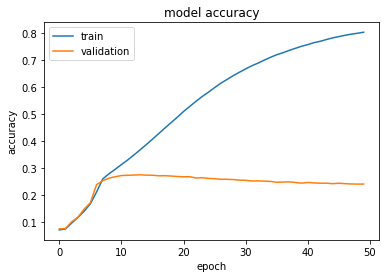

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


Generate text

In [20]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=0.3):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=[None,None]):
    # Convert strings to token IDs.
    input_chars = tf.strings.split(inputs)
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    mStates, cStates = None, None
    predicted_logits, mStates, cStates = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, mStates,cStates

In [21]:
one_step_model = OneStep(model, vocab_from_ids, ids_from_vocab)
start = time.time()
mStates,cStates = None,None
next_char = tf.constant(['یکی'])
result = [next_char]

for n in range(69):
  next_char, mStates,cStates = one_step_model.generate_one_step(next_char, states=[mStates,cStates])
  result.append(next_char)

result = tf.strings.join(result, separator=' ')
end = time.time()
print(result[0].numpy().decode('utf-8').replace("***", "\n"), '\n\n' + '_'*80)
print('\nRun time:', end - start)

یکی تیغ زد بر سر کتف اوی ** ببوسم بدو بر کسی کاو بس 
 شمار سرافراز و بانگ و نفیر ** برو بر نشسته یکی پهلوان 
 هم از شهر سر سوی سالار شاه ** کسی را نبد آرزو در نهان 
 بپرسید کز خواب بیدار شد ** به هر بد که اندیشی آزاد کرد 
 وزان پس بفرمود شاه اردشیر ** ببخشید چیزی که بد کرد بر 
 

________________________________________________________________________________

Run time: 1.2285466194152832


Accuracy of test set

Accuracy for test set:  0.23258827340459995


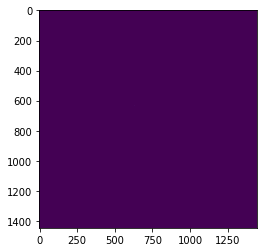

In [25]:
test_seq_length = 50
test_slices = np.array([text[:test_seq_length] for text in test_ids])
X_test = []
Y_test = []
for row in test_slices:
  x,y = split_input_target(row)
  X_test.append(x)
  Y_test.append(y)
X_test = np.array(X_test)
Y_test = np.array(Y_test)
predictions = np.array(model.predict(X_test))
sampled_indices = [tf.random.categorical(predictions[i], num_samples=1) for i in range(len(predictions))]
sampled_indices = [tf.squeeze(sampled_indices[i], axis=-1).numpy() for i in range(len(predictions))]
sampled_indices = np.array(sampled_indices)
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
conf = confusion_matrix(Y_test.ravel(), sampled_indices.ravel())
print("Accuracy for test set: ", accuracy_score(Y_test.ravel(), sampled_indices.ravel()))
plt.imshow(conf)
plt.show()


Prepare dataset for bleu



In [27]:
X_test_split = []
Y_test_split = []
for i in range(len(test_slices)):
  text = text_from_ids(X_test[i])
  X_test_split.append(text.numpy().decode('utf-8'))
  text = text_from_ids(Y_test[i])
  Y_test_split.append(text.numpy().decode('utf-8'))
print(X_test_split[0])

پس آگاهی آمد به بهرام گور ** که از چرخ شد تخت را آب شور *** پدرت آن سرافراز شاهان بمرد ** به مرد و همه نام شاهی ببرد *** یکی مرد بر گاه بنشاندند ** به شاهی همی خسروش خواندند *** بخوردند سوگند یکسر سپاه ** کزان تخمه


In [28]:
predicts = []

for i,poem in enumerate(X_test_split):
  next_char = tf.constant([poem.split(" ")[0]])
  result = [next_char]
  for n in range(test_seq_length-1):
    next_char, mStates,cStates = one_step_model.generate_one_step(next_char, states=[mStates,cStates])
    result.append(next_char)
  
  result = tf.strings.join(result," ")
  result = result[0].numpy().decode('utf-8')
  predicts.append(result)

In [31]:
print(predicts[7].replace("***","\n"), '\n\n' + '_'*80)
print(predicts[5].replace("***","\n"), '\n\n' + '_'*80)
print(predicts[43].replace("***","\n"), '\n\n' + '_'*80)

به هر دو سپه را سپرد 
 به پیش بزرگان لشگر گرفت ** پذیره شدن را بیاراست شاه 
 ز جهرم پیر تا قلب و پر ** وزان روی خسرو بیاورد گرم 
 ز بس رامش و پر گزندان بدند ** به یک جای بینیش سوراخ کرد 
 مهاری به 

________________________________________________________________________________
چو از آفرین خدای ** چه کرد آن جهاندیده گستهم 
 بیاورد لشکر ز جای نشست ** کمر تنگ بستش به باغ بهار 
 همی سوخت باغ و همی ** چو دریا رخ آورد و بر 
 چو از دور لهاک و فرشیدورد ** به سر برنهاده کلاه کیان 
 

________________________________________________________________________________
چو برزد ز آب ** نیابد ازو گاه و آرایش موی 
 سر لشکر از جام می برگرفت ** چو نخچیربانان که اندر گرفت 
 بدو گفت کای مرد فرهنگ جوی ** یکی رای قیصر سزاوار کیست 
 فرستاده گفت ای خردمند مرد ** چرا روز نو گردد تباه این 

________________________________________________________________________________


In [32]:

predict_split = []
for i in range(len(predicts)):
  text = predicts[i].replace("\t", " \t ").replace("\n", " \n ").split(" ")
  predict_split.append(text)


In [34]:
import nltk
bleu = 0
for i in range(len(predict_split)):
  hypothesis = predict_split[i]
  reference = X_test_split[i].split(" ")
  BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis, weights = [1])
  bleu += BLEUscore
print(bleu/len(predict_split))

0.26888888888888884
